# Demonstrates use of LSTM

## Initialize

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import tensorflow as tf
import os
import matplotlib.pyplot as plt, numpy as np,  pandas as pd
from sklearn.preprocessing import MinMaxScaler

root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('./local_data')

## Demonstrate the data

In [2]:
data_file_name = os.path.join(data_folder, 'ER admission_1.csv')
raw_data = pd.read_csv(data_file_name)
raw_data['t'] = pd.to_datetime(raw_data['t'])
raw_data = raw_data.reset_index(drop=True).set_index('t')
raw_data.head()

,n
t,
2004-01-01 00:00:00,5
2004-01-01 01:00:00,8
2004-01-01 02:00:00,8
2004-01-01 03:00:00,8
2004-01-01 04:00:00,0


<Figure size 1200x900 with 0 Axes>

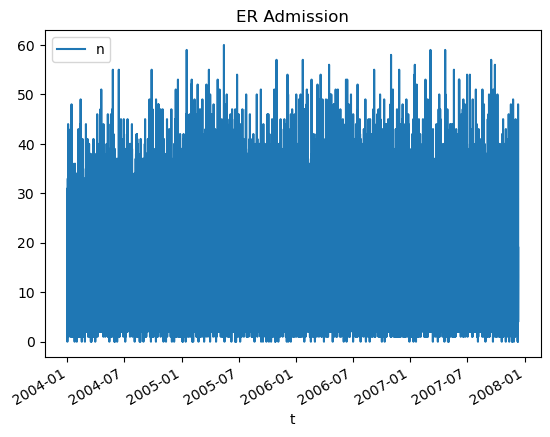

In [3]:
plt.figure(figsize=(12,9))
raw_data.plot(y='n'); 
plt.title('ER Admission'); # how many patients admit in the ER each hour.

### Short term pattern

<Figure size 1200x900 with 0 Axes>

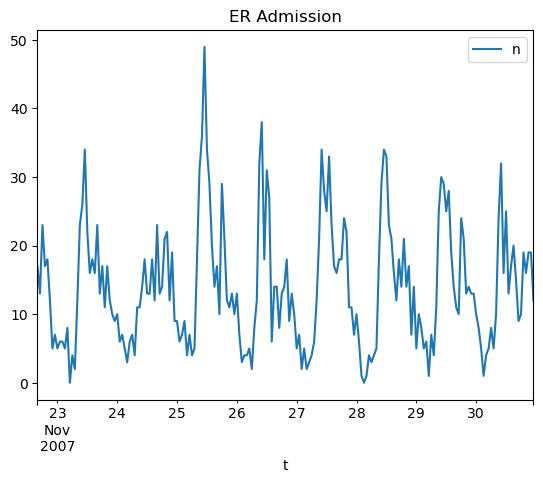

In [4]:
plt.figure(figsize=(12,9))
raw_data.iloc[-200:].plot( y='n'); 
plt.title('ER Admission');

### Monthly average

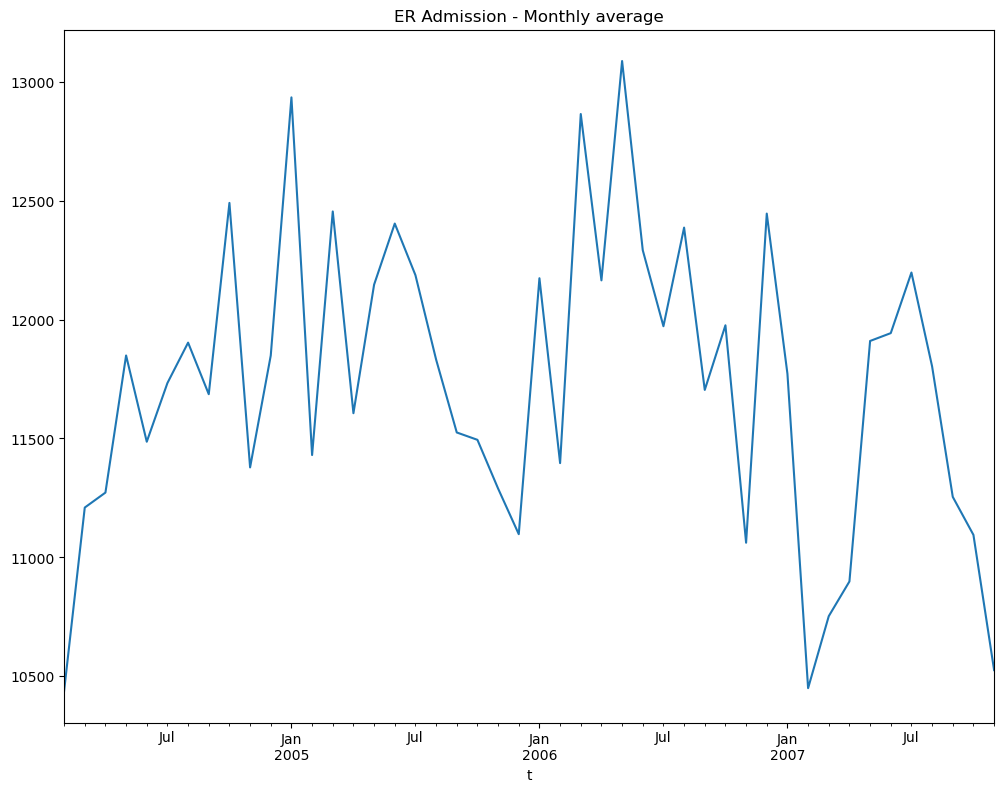

In [5]:
plt.figure(figsize=(12,9))
raw_data.groupby(pd.Grouper(freq='M'))['n'].sum()[1:-1].plot();
plt.title('ER Admission - Monthly average');

## Custom Dataset Class

<img src="lstm_data_arrangement.png"></img>

### Generate the data

In [6]:
def sliding_windows(data, history_samples, horizon_samples):
    x = []
    y = []

    for i in range(len(data)-history_samples-horizon_samples):
        _x = data.iloc[i:(i+history_samples)]
        _y = data.iloc[i+history_samples:i+history_samples+horizon_samples]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)


In [7]:
history_samples=24*14
horizon_samples=24*3

# split into train and test sets
train_size = int(len(raw_data) * 0.9)-(history_samples+horizon_samples)
test_size = len(raw_data) - (train_size  + history_samples + horizon_samples)

train_data = raw_data.iloc[:train_size].copy()
test_data = raw_data.iloc[-test_size:].copy()

#normalize the data:
sc = MinMaxScaler()
sc.fit(train_data[['n']] )

train_data[['n']] = sc.transform(train_data[['n']] )
test_data[['n']] = sc.transform(test_data[['n']] )

# create train and test sets
trainX, trainY = sliding_windows(train_data, history_samples, horizon_samples)
testX, testY = sliding_windows(test_data, history_samples, horizon_samples)


In [8]:
print(f'Data set: {len(raw_data)}. history size: {history_samples}. Prediction window size: {horizon_samples} ')
print(f'Data set: \t From: {raw_data.index[0]} to {raw_data.index[-1]}')
print(f"Train set: {len(train_data)}: from {train_data.index[0]} to: {train_data.index[-1]}")
print(f"Test set: {len(test_data)}: from {test_data.index[0]} to: {test_data.index[-1]}")
print(f"sample size: x: {trainX[0].shape}, y: {trainY[0].shape}")

Data set: 34320. history size: 336. Prediction window size: 72 
Data set: 	 From: 2004-01-01 00:00:00 to 2007-11-30 23:00:00
Train set: 30480: from 2004-01-01 00:00:00 to: 2007-06-23 23:00:00
Test set: 3432: from 2007-11-07 00:00:00 to: 2007-11-30 23:00:00
sample size: x: (336, 1), y: (72, 1)


- X dimensions:  history size to learn from (14 days) x number of channels (1)
- Y dimensions:  number of samples to predict  x 1 (number of channels)

In [9]:
trainX.shape, trainY.shape

((30072, 336, 1), (30072, 72, 1))

#### Single sample

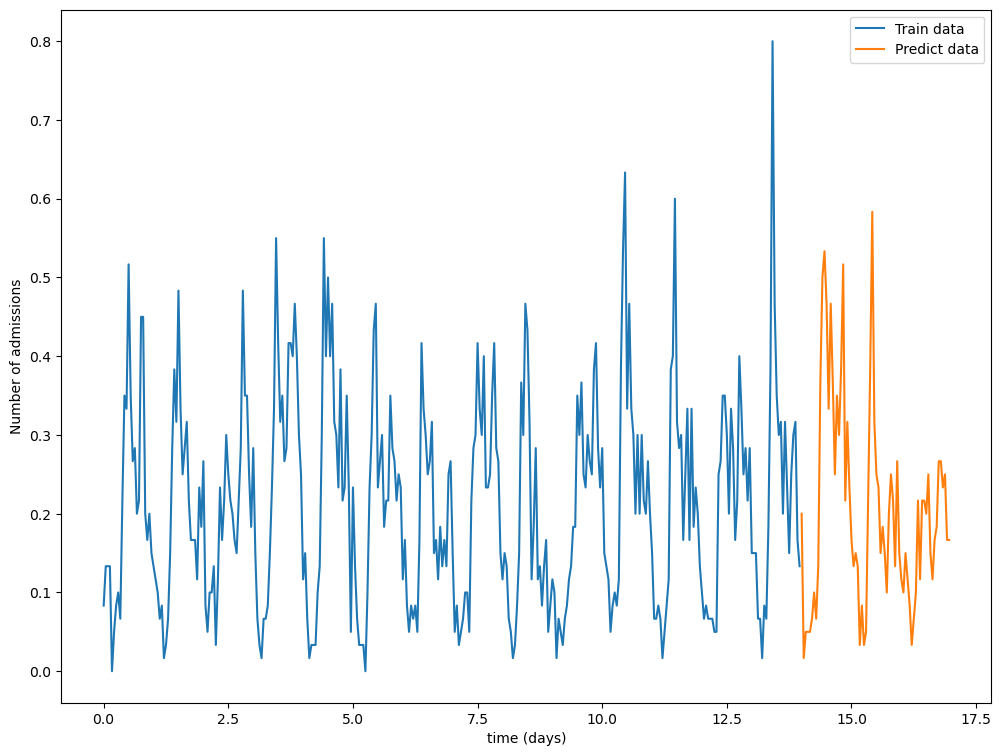

In [10]:
plt.figure(figsize=(12,9))
x = trainX[0]
y = trainY[0]

plt.plot(np.arange(0, history_samples)/24, x.squeeze(), label='Train data')
plt.plot(np.arange(history_samples, history_samples + horizon_samples)/24, y, label='Predict data')
plt.legend(); plt.xlabel('time (days)'); plt.ylabel('Number of admissions');

## Test LSTM Layer
<img src="aTDpS.png"></img>

### Single layer
LSTM layer parameters:
- <code>input_size</code>: number of features in every time sample $X_t$. For simple time series: 1
- <code>hidden_size</code>: number of features in the hidden state $h$. This defines the vector output by LSTM (and size of the input to the next layer. This also defines the size of the memory vector $c$
- <code>batch_first</code>. Boolean (False by default). Defines the order of dimensions in $X$. 
    - False: (sequence, batch, feature)
    - True: (batch, sequence, feature)

In [11]:
x,y = trainX[0:2], trainY[0:2]
x.shape, y.shape

((2, 336, 1), (2, 72, 1))

#### Demonstrate application of LSTM layer
https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [12]:
from tensorflow.keras.layers import LSTM
lstm = LSTM(units=100)
lstm(x).shape

TensorShape([2, 100])

#### Stack few inputs into batch
to stack several LSTM layers, one has to request that inner-LSTM layers return sequence of hidden states. 

In [13]:
from tensorflow.keras.layers import LSTM
lstm1 = LSTM(units=100, return_sequences=True) 
lstm1(x).shape

TensorShape([2, 336, 100])

In [14]:
from tensorflow.keras.layers import LSTM
lstm1 = LSTM(units=100, return_sequences=True) 
lstm2 = LSTM(units=100, return_sequences=False) 
lstm2(lstm1(x)).shape

TensorShape([2, 100])

#### LSTM Implementation and Parameters
<img src="aTDpS.png"></img>

weights order: 
- $f$ - forgetfullness 
- $i$ - input / impute
- $c_{in}$ - magnitude of imputed memory
- $o$ - output

In [15]:
from tensorflow.keras.layers import LSTM
lstm = LSTM(units=100)
lstm(x)
for weights_index, weights in enumerate(lstm.weights): # weights are created only after the first call of "forward pass"
    print(weights_index, weights.shape)

0 (1, 400)
1 (100, 400)
2 (400,)


### Parameter explanation
- Inputs / Outputs
    - $X$ of size batch x 336  x 1. (1 - number of features / concurrent time series to process)
    - $h$ - hidden state: batch x 1 x 100
    - $c$ - memory state: batch x 1 x 100
- Trainable parameters (in terms of neurons): 
    - $"X" (input) layer$: 4 Neurons, input size: 1x1, output size: 1x100. Represented by the matrix $W_i$
        - "Neuron $X_1$", applied to $X$ to contribute to $i$
            - $W_{ii}$ - 100x1
            - $b_{ii}$ - 100x1
        - "Neuron $X_2$", applied to $X$ to contribute to $f$
            - $W_{if}$ - 100x1            
            - $b_{if}$ - 100x1
        - "Neuron $X_3$", applied to $X$ to contribute to $g$
            - $W_{ig}$ - 100x1
            - $b_{ig}$ - 100x1    
        - "Neuron $X_4$", applied to $X$ to contribute to $o$
            - $W_{io}$ - 100x1
            - $b_{io}$ - 100x1
    - $"h" (hidden) layer$: 4 Neurons, input size: 1x100, output size: 1x100. Represented by the matrix $W_h$
        - "Neuron $h_1$", applied to $h$ to contribute to $i$
            - $W_{ii}$ - 100x100
            - $b_{ii}$ - 100x1
        - "Neuron $h_2$", applied to $h$ to contribute to $f$
            - $W_{if}$ - 100x100            
            - $b_{if}$ - 100x1
        - "Neuron $h_3$", applied to $h$ to contribute to $g$
            - $W_{ig}$ - 100x100
            - $b_{ig}$ - 100x1    
        - "Neuron $h_4$", applied to $h$ to contribute to $o$
            - $W_{io}$ - 100x100
            - $b_{io}$ - 100x1            

## Define and train the model

### Define the network

In [16]:
def generate_model(lstm_hidden_dim, num_lstm_layers, output_dim):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM,  Dense, Reshape
    model =  Sequential()
    for lstm_layer_index in range(num_lstm_layers-1):
        model.add(LSTM(units=lstm_hidden_dim, return_sequences=True , activation="tanh") )     
    model.add(LSTM(units=lstm_hidden_dim))
    model.add(Dense(300, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(output_dim, activation=None))
    model.add(Reshape( (output_dim, 1)))
    return model

In [17]:
model = generate_model(lstm_hidden_dim=100, num_lstm_layers=2, output_dim=72)

In [18]:
model(testX[:10]).shape

TensorShape([10, 72, 1])

### Train the network
~3.5min

In [19]:
model_file_name = os.path.join(data_folder, 'ER Admission - LSTM-1')

if not os.path.isdir(model_file_name):    
    model = generate_model(lstm_hidden_dim=100, num_lstm_layers=1, output_dim =testY.shape[1])
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=15, batch_size=200, verbose=0)    
    pd.DataFrame(history.history).to_csv(model_file_name + '.csv')
    model.save(model_file_name)        
model = tf.keras.models.load_model(model_file_name)
history = pd.read_csv(model_file_name + '.csv', index_col=0)

Text(0, 0.5, 'MSE')

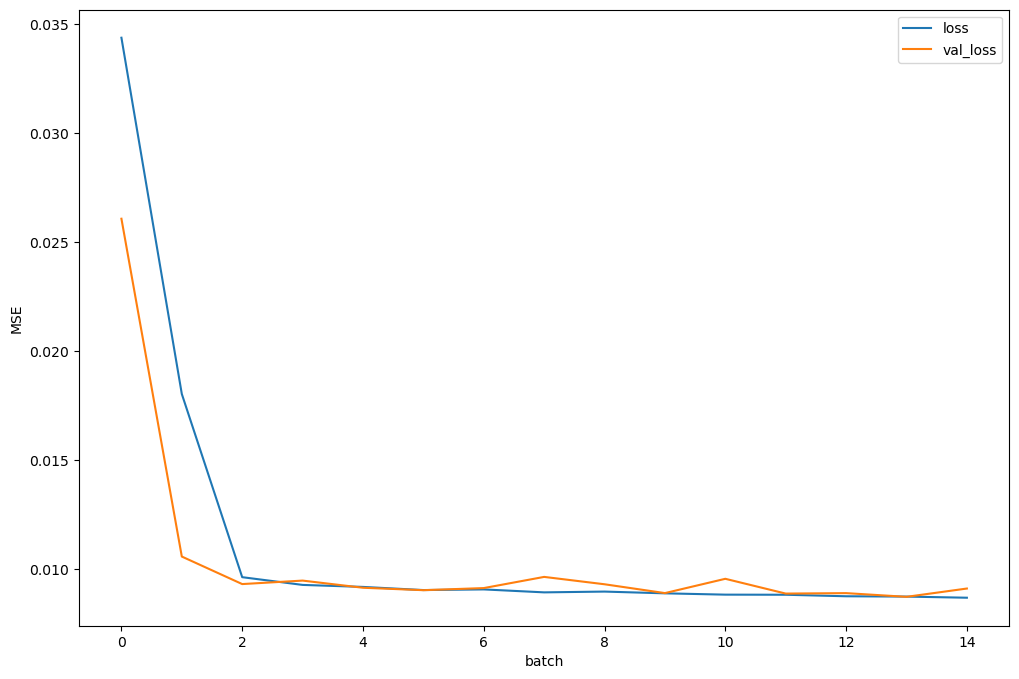

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
history.plot(ax=ax)
ax.set_xlabel('batch'); ax.set_ylabel('MSE')

## Explore the model

### Compute average accuracy

In [21]:
test_accuracy = model.evaluate(testX, testY)
print(f"test  : {test_accuracy}")

95/95 [==============================] - 5s 46ms/step - loss: 0.0090
test accuracy: 0.009038473479449749


### Predicting the future

1/1 [==============================] - 0s 382ms/step


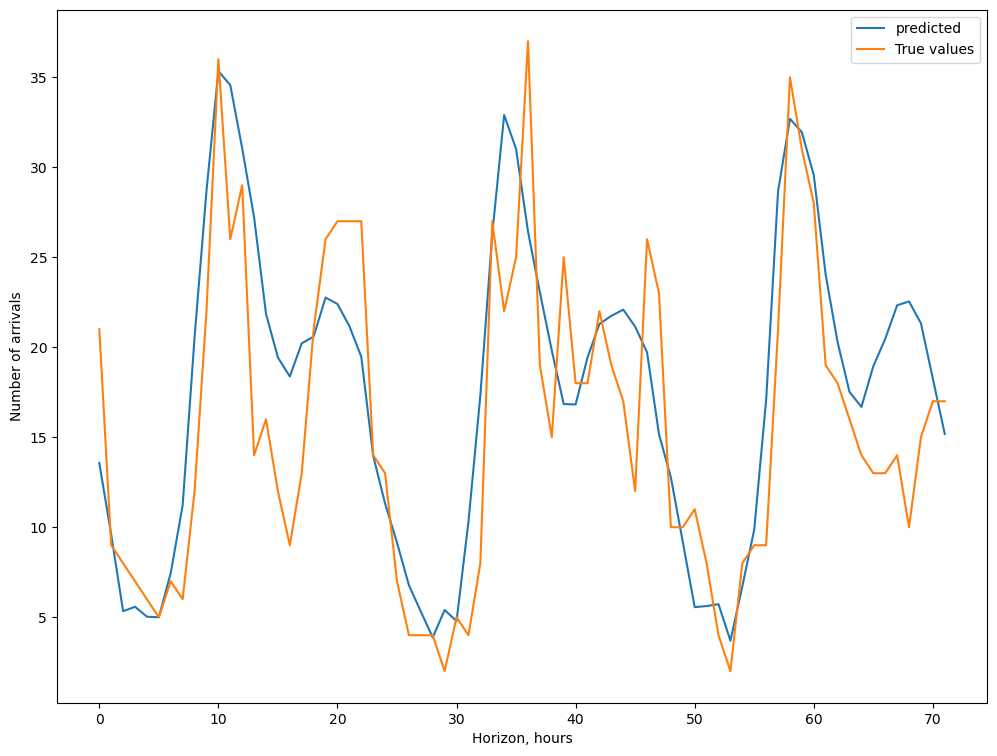

In [22]:
predY = model.predict(testX[0:1]).reshape(-1,1)
trueY = testY[0:1].reshape(-1,1)
plt.figure(figsize=(12,9))
plt.plot(sc.inverse_transform(predY), label='predicted')
plt.plot(sc.inverse_transform(trueY), label='True values')
plt.xlabel('Horizon, hours');
plt.ylabel('Number of arrivals');
plt.legend()

### Prediction of the first point

7/7 [==============================] - 0s 43ms/step


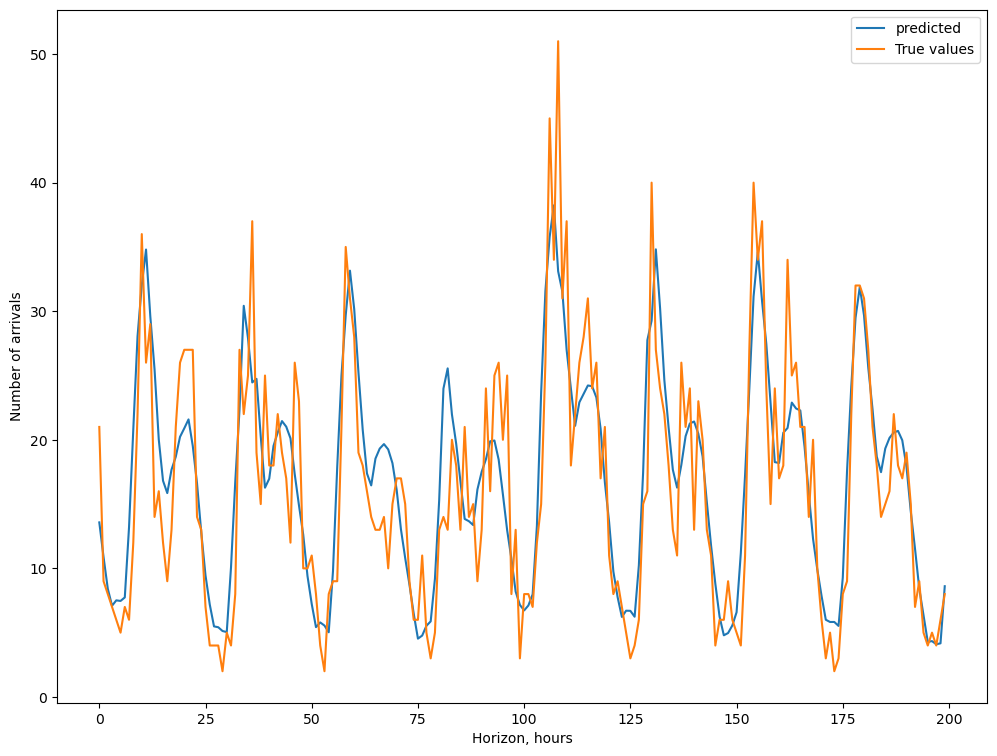

In [23]:
time_offset = 0
predY = model.predict(testX[0:200])[:,time_offset] # extract only the first time point for each of the 200 predictions. 
trueY = testY[0:200][:,time_offset]
plt.figure(figsize=(12,9))
plt.plot(sc.inverse_transform(predY), label='predicted')
plt.plot(sc.inverse_transform(trueY), label='True values')
plt.xlabel('Horizon, hours');
plt.ylabel('Number of arrivals');
plt.legend()


### Compute MSE over prediction horizon
Note that the  model produces prediction for 72h into the future. The current loss minimizes the average means square error.<br>
In general, we expect the accuracy to drop as prediction range increases. 

In [24]:
from sklearn.metrics import mean_squared_error
predY = model.predict(testX, batch_size=200) # extract only the first time point for each of the 200 predictions. 
trueY = testY
mse = np.zeros( (predY.shape[1],) , dtype=np.float32)
for time_offset in range(predY.shape[1]):
    mse[time_offset] = mean_squared_error(y_true=trueY[:,time_offset, 0], y_pred= predY[:,time_offset, 0])

16/16 [==============================] - 7s 442ms/step


Text(0, 0.5, 'MSE')

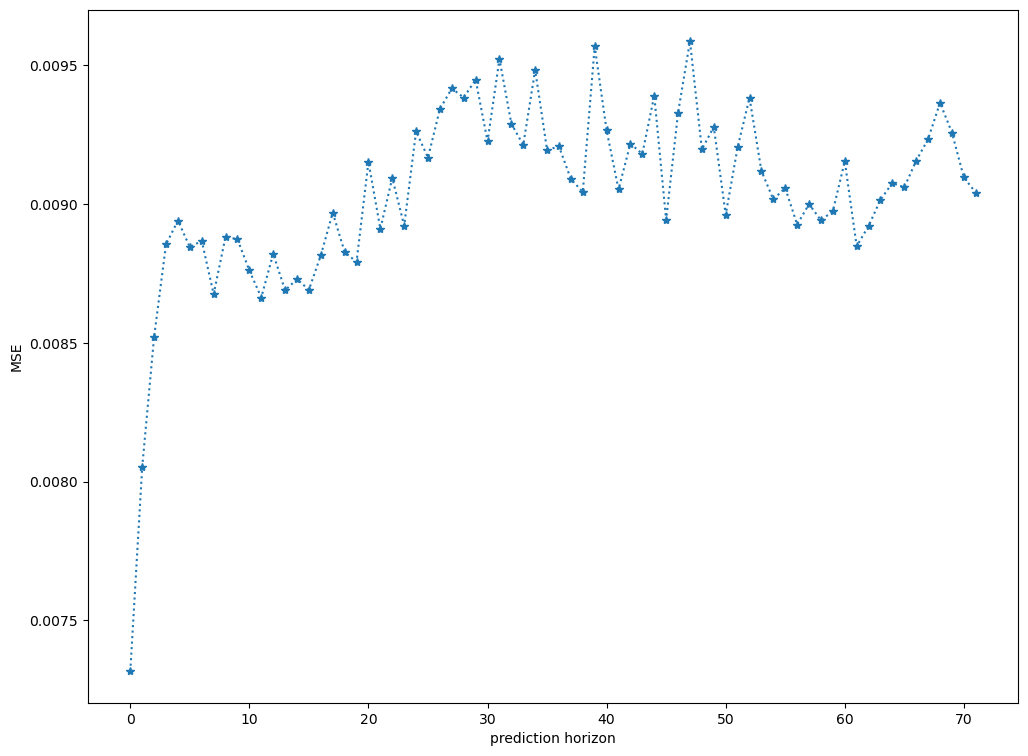

In [25]:
plt.figure(figsize=(12,9))
plt.plot(mse, '*:')
plt.xlabel('prediction horizon')
plt.ylabel('MSE')